In [145]:
import open3d as o3d
import open3d.core as o3c
import numpy as np
import pickle
import math
import matplotlib.pyplot as plt
import copy


In [141]:
with open('data/odom.pickle', 'rb') as handle:
    odom_data = pickle.load(handle)
with open('data/p3d.pickle', 'rb') as handle:
    p3d_data = pickle.load(handle)
with open('data/pc2.pickle', 'rb') as handle:
    pc2_data = pickle.load(handle)    

pcd = []
for pc2_pointcloud in pc2_data:
    o3d_pointcloud = o3d.geometry.PointCloud()
    o3d_pointcloud.points = o3d.utility.Vector3dVector(np.array(pc2_pointcloud))
    pcd.append(o3d_pointcloud)

In [119]:
combined_pc = pcd[0]

for i in range(len(pcd)-150):
    result_icp = o3d.pipelines.registration.registration_icp(
        pcd[i], pcd[i+1], 0.1, np.identity(4),
        o3d.pipelines.registration.TransformationEstimationPointToPoint())
    transformation = result_icp.transformation
    combined_pc = combined_pc.transform(transformation) + pcd[i+1]


In [120]:
o3d.visualization.draw_geometries([combined_pc])

In [58]:
def draw_registration_result_original_color(source, target, transformation):
    source_temp = copy.deepcopy(source)
    source_temp.transform(transformation)
    
    source_array = np.asarray(source_temp.points)
    target_array = np.asarray(target.points)

    fig, ax = plt.subplots()
    ax.plot(source_array[:,0],source_array[:,1],'ro')
    ax.plot(target_array[:,0],target_array[:,1],'bo')
    ax.grid() 
    ax.set_aspect('equal')
    plt.show() 
    # o3d.visualization.draw_geometries([source_temp, target])

def vector_to_matrix(x):
    X = np.array([[np.cos(x[2]), -np.sin(x[2]), x[0]],
                [np.sin(x[2]), np.cos(x[2]), x[1]],
                [0, 0, 1]
                ])
    return X

def diff_vector(x_i, x_j):
    X_i = vector_to_matrix(x_i)
    X_j = vector_to_matrix(x_j)
    V_ij = np.dot(np.linalg.inv(X_i),X_j)
    return matrix_to_vector(V_ij)

def matrix_to_vector(X):
    x = np.array([X[0][2], X[1][2], math.atan2(X[1][0], X[0][0])]) 
    return x

def theta_to_rotation_matrix(theta):
    R = np.array([[np.cos(theta),   -np.sin(theta)],
                  [np.sin(theta),   np.cos(theta)]])
    return R

def theta_to_rotation_matrix_derivative(theta):
    R_derivative = np.array([[-np.sin(theta),   -np.cos(theta)],
                             [np.cos(theta),   -np.sin(theta)]])
    return R_derivative

def rotation_matrix_to_theta(R):
    theta = math.atan2(R[1][0], R[0][0])
    return theta



class Link:
    def __init__(self, infor_matrix, edge_vector, node_1, node_2):
        self.__infor_matrix = infor_matrix
        self.__edge_vector = edge_vector
        self.__node_1 = node_1
        self.__node_2 = node_2
        self.__A_ij = np.identity(3)
        self.__B_ij = np.identity(3)
        self.__error_vector = np.ones((1,3))

    def read_vector(self):
        return self.__edge_vector 

    def read_jacobi(self):
        matrix1 = np.dot(theta_to_rotation_matrix(self.__edge_vector[2]).T,
                         theta_to_rotation_matrix(self.__node_1.read_state()[2]).T)
        matrix2 = np.dot(theta_to_rotation_matrix(self.__edge_vector[2]).T, 
                         np.dot(theta_to_rotation_matrix_derivative(self.__node_1.read_state()[2]).T, 
                                self.__node_2.read_state()[:2]-self.__node_1.read_state()[:2]) )
        self.__A_ij = np.vstack( (np.hstack((-matrix1,matrix2.reshape(2,1))), np.array([0,0,-1.0])) )
        self.__B_ij = np.vstack( (np.hstack((matrix1,np.zeros((2,1)))), np.array([0,0,1.0])) )
        return(self.__A_ij, self.__B_ij)

    def read_error(self):
        error_matrix = np.dot(np.linalg.inv(vector_to_matrix(self.__edge_vector)), 
                              np.dot(np.linalg.inv(vector_to_matrix(self.__node_1.read_state())),
                                     vector_to_matrix(self.__node_2.read_state())))
        self.__error_vector = matrix_to_vector(error_matrix)
        return(self.__error_vector)

    def read_node_num(self):
        return (self.__node_1.read_num(), self.__node_2.read_num())
    
    def read_info(self):
        return self.__infor_matrix
    

    

class Node:
    def __init__(self, state_vector):
        self.__num = 0
        self.__state_vector = state_vector

    def resort(self, num):
        self.__num = num

    def read_state(self):
        return self.__state_vector
    
    def set_state(self, state):
        self.__state_vector = state

    def read_num(self):
        return self.__num

In [129]:
obv_coord  =[np.zeros((3))]
for i in range(len(pcd)-150):
    result_icp = o3d.pipelines.registration.registration_icp(
        pcd[i], pcd[i+1], 0.1, np.identity(4),
        o3d.pipelines.registration.TransformationEstimationPointToPoint())
    trans_matrix = np.linalg.inv(result_icp.transformation)
    trans_matrix_2d = np.delete(np.delete(trans_matrix,2,1), 2, 0)
    target_matrix = np.dot(vector_to_matrix(obv_coord[i]),trans_matrix_2d)
    target_vector = matrix_to_vector(target_matrix)
    obv_coord.append(target_vector)

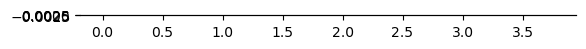

In [126]:
fig, ax = plt.subplots()
for pos in obv_coord:
    ax.plot(pos[0],pos[1],'yo')

ax.grid() 
ax.set_aspect('equal')
plt.show() 

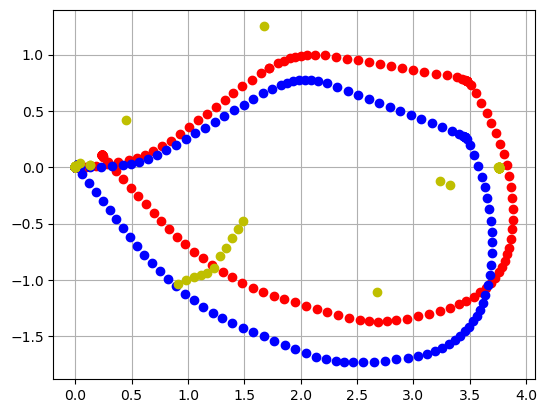

In [130]:
fig, ax = plt.subplots()
for pos in odom_data:
    ax.plot(pos[0],pos[1],'ro')

for pos in p3d_data:
    ax.plot(pos[0],pos[1],'bo')

for pos in obv_coord:
    ax.plot(pos[0],pos[1],'yo')

ax.grid() 
ax.set_aspect('equal')
plt.show() 